## set running directory to project source

In [1]:
import os
import numpy as np
import time
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))
import matplotlib.pyplot as plt

## 4.1 PlanningScene

##### initialize CombinedRobot and GeometryScene

In [2]:
from pkg.controller.combined_robot import *
from pkg.project_config import *
from pkg.geometry.builder.scene_builder import SceneBuilder

s_builder = SceneBuilder(None)   # create scene builder without detector for virtual scene
crob = CombinedRobot(robots_on_scene=[
    RobotConfig(0, RobotType.indy7gripper, ((0,0,0), (0,0,0)), None)]
                     , connection_list=[False])
gscene = s_builder.create_gscene(crob)
gtems = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True)
gscene.show_pose(crob.home_pose)

connection command:
indy0: False
Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.


Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


##### add geometries

In [3]:
from pkg.geometry.geometry import *

# add environments (fixed=True for non-movable geometries)
wall = gscene.create_safe(GEOTYPE.BOX, "wall", "base_link", (3,3,0.01), (-0.2,0,0), 
                           rpy=(0,np.pi/2,0), color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=True)
floor = gscene.create_safe(GEOTYPE.BOX, "floor", "base_link", (3,3,0.01), (0,0,0), 
                           rpy=(0,0,0), color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=True)
wp1 = gscene.create_safe(GEOTYPE.BOX, "wp1", "base_link", (0.1,0.1,0.01), (0.6,-0.3,0),rpy=(0,0,0), 
                         color=(0.8,0.2,0.2,1), display=True, fixed=True, collision=False, parent="floor")
wp2 = gscene.create_safe(GEOTYPE.BOX, "wp2", "base_link", (0.1,0.1,0.01), (0.2,-0.3,0), rpy=(0,0,0), 
                         color=(0.8,0.2,0.2,1), display=True, fixed=True, collision=False, parent="floor")
goal = gscene.create_safe(GEOTYPE.BOX, "goal", "base_link", (0.1,0.1,0.01), (0.3,-0.4,0), 
                          rpy=(0,0,0), color=(0.2,0.2,0.8,1), display=True, fixed=True, collision=False)
 
# add movable (fixed=False for movable geometries)
box1 = gscene.create_safe(GEOTYPE.BOX, "box1", "base_link", (0.05,0.05,0.05), (0.3,0.4,0.031), 
                          rpy=(0,0,0), color=(0.8,0.2,0.2,1), display=True, fixed=False, collision=True)

obstacle = gscene.create_safe(GEOTYPE.BOX, "obstacle", "base_link", (0.05,0.05,0.05), (0.5,0.4,0.031), 
                          rpy=(0,0,0), color=(0.8,0.8,0.2,1), display=True, fixed=False, collision=True)

##### create PlanningScene

In [4]:
from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

##### create_binder
- Binders (or Actors) are binding points where objects can be attached (or binded)
- Examples are 
  - PlacePlane: plane for object placement
  - Gripper2Tool: 2-finger gripper tool for grasp objects
  - SweepTool: action point to pass waypoints for sweep task

In [5]:
from pkg.planning.constraint.constraint_actor import PlacePlane, Gripper2Tool, SweepFramer

In [6]:
# create PlacePlane on geometry "floor" and "goal"
# when point is not set, the entire upper surface of the geometry becomes valid binding area.
# when point is set, the specific point becomes the only valid binding point.
pscene.create_binder(bname="floor", gname="floor", _type=PlacePlane)
pscene.create_binder(bname="goal", gname="goal", _type=PlacePlane, point=(0,0,0.005))

In [7]:
# add collision boundary for gripper base
# - set link_name="indy0_tcp" to attach the geometry to end-effector link
# - it can be labeled as fixed=True, as it is "fixed" on the indy0_tcp link
gripper =  gscene.create_safe(GEOTYPE.SPHERE, "grip0", link_name="indy0_tcp", 
                                dims=(0.01,0.01,0.01), center=(0,0,0.14), rpy=(-np.pi/2,0,0), 
                                color=(0.8,0.2,0.2,0.5), display=True, fixed=True, collision=False)

# create Gripper2Tool binder
# Gripper2Tool is a 2-finger gripper, which can rotate along z-direction.
# To align the z-direction with the 2 fingers, rotate by 90 degree along roll axis.
# The gripping point is (0,0,0.11) in local coordinate of "gripper" geometry
pscene.create_binder(bname="grip0", gname="grip0", _type=Gripper2Tool)

In [8]:
# Add virtual (no-collision) sweep face. the point is 0.2 m away from the "indy0_tcp" link
# To match the z-direction with the target surface, the geometry is rotated 180 degrees in pitch-axis.
sweep_face =  gscene.create_safe(GEOTYPE.BOX, "sweep_face", link_name="indy0_tcp", 
                                dims=(0.05,0.05,0.001), center=(0,0,0.2), rpy=(0,np.pi,0), 
                                color=(0.2,0.2,0.8,0.1), display=True, fixed=True, collision=False)
                                 
# create SweepTool binder
pscene.create_binder(bname="sweep_face", gname="sweep_face", _type=SweepFramer, point=(0,0,0), rpy=(0,0,0))

##### create_subject
* Subject describes the tasks in the planning scene.
* There are 2 categories in subject:
  1. Object: The object has grip points and placement points for pick&place task
  2. Task: The task is can be any non-physical task. Check SweepLineTask for example
* The subjects can be composed of multiple action points. Examples are:
  1. Grasp2Point: grasping point for 2-finger gripper. 
  2. PlacePoint: The point to place object.
  3. SweepPoint: A waypoint for SweepLineTask.
  * The above 3 action points inherit DirectePoint, for which the orientation is free along z-axis. 
  * If "point" parameter is not set, the entire upper surface is becomes valid action area.

In [9]:
from pkg.planning.constraint.constraint_subject import Grasp2Point, PlacePoint, SweepFrame
from pkg.planning.constraint.constraint_subject import CustomObject, SweepLineTask

In [10]:
## create box object with grasping points along positive & negative y-direction and placement point in the bottom face
box_obj = pscene.create_subject(oname="box1", gname="box1", _type=CustomObject, 
                             action_points_dict = {
                                 "handle1": Grasp2Point("handle1", box1, [0,0,0], [-np.pi/2,0,0]),
                                 "handle2": Grasp2Point("handle2", box1, [0,0,0], [np.pi/2,0,0]),
                                 "bottom": PlacePoint("bottom", box1, [0,0,-0.026], [0,0,0])})

In [11]:
## create sweep task with 2 waypoints
sweep = pscene.create_subject(oname="sweep", gname="floor", _type=SweepLineTask, 
                             action_points_dict = {"wp1": SweepFrame("wp1", wp1, [0,0,0.005], [0,0,0]),
                                                   "wp2": SweepFrame("wp2", wp2, [0,0,0.005], [0,0,0])}
                             )

##### initialize_state
* initialize_state(robot_pose) updates robot pose and gets corresponding binding status of current scene.
* state.node of ('floor', 0) means the first subject (object) is placed on the floor and the second subject (sweep) has passed 0 waypoints

In [12]:
initial_state = pscene.initialize_state(crob.home_pose)
print(initial_state.node)

('floor', 0)


## Copy urdf file

In [13]:
from shutil import copyfile
import rospkg
rospack = rospkg.RosPack()
def copyfile_callback(line, string_from="package://", path_to="./"):
    i_s = line.find(string_from)
    i_e = line.rfind('"')
    if i_e<=0:
        i_e = line.rfind("'")
    file_pkg = line[i_s+len(string_from):i_e]
    file_split = file_pkg.split('/')
    pkg = file_split[0]
    path_pkg = rospack.get_path(pkg)
    path_cur = path_to
    for folder in file_split[:-1]:
        path_cur = os.path.join(path_cur, folder)
        try_mkdir(path_cur)
    try: copyfile(os.path.join(path_pkg, *file_split[1:]), os.path.join(path_to, file_pkg))
    except: pass

In [14]:
upath_ext_split = gscene.urdf_path.split(".")
urdf_pybullet_path = ".".join(upath_ext_split[:-1])+"_pybullet."+upath_ext_split[-1]
path_to = os.path.dirname(urdf_pybullet_path)
copyfile_replace(gscene.urdf_path, urdf_pybullet_path, "package://", "./", 
                 line_callback=lambda line, string_from, string_to: copyfile_callback(line, string_from, path_to))

## Test pybullet

In [15]:
#!/usr/bin/env python

from __future__ import print_function

import os
import sys
RNB_PLANNING_DIR = os.environ['PDDL_STREAM_DIR']
sys.path.insert(1, os.environ["PDDL_STREAM_DIR"])

from pddlstream.algorithms.meta import solve, create_parser
from examples.pybullet.utils.pybullet_tools.utils import WorldSaver, connect, get_pose, set_pose, Pose, \
    Point, set_default_camera, stable_z, \
    BLOCK_URDF, SMALL_BLOCK_URDF, get_configuration, SINK_URDF, STOVE_URDF, load_model, is_placement, get_body_name, \
    disconnect, DRAKE_IIWA_URDF, get_bodies, HideOutput, wait_for_user, KUKA_IIWA_URDF, add_data_path, load_pybullet, \
    LockRenderer, has_gui, draw_pose, draw_global_system, CLIENTS, CLIENT, is_darwin, disable_preview, get_model_path
from pddlstream.language.generator import from_gen_fn, from_fn, empty_gen, from_test, universe_test
from pddlstream.utils import read, INF, get_file_path, find_unique, Profiler, str_from_object, negate_test
from pddlstream.language.constants import print_solution, PDDLProblem
from examples.pybullet.tamp.streams import get_cfree_approach_pose_test, get_cfree_pose_pose_test, get_cfree_traj_pose_test, \
    move_cost_fn, get_cfree_obj_approach_pose_test

In [16]:

import platform
import pybullet as p
def connect(use_gui=True, shadows=True, color=None, width=None, height=None):
    # Shared Memory: execute the physics simulation and rendering in a separate process
    # https://github.com/bulletphysics/bullet3/blob/master/examples/pybullet/examples/vrminitaur.py#L7
    # make sure to compile pybullet with PYBULLET_USE_NUMPY enabled
    if use_gui and not is_darwin() and ('DISPLAY' not in os.environ):
        use_gui = False
        print('No display detected!')
    method = p.GUI if use_gui else p.DIRECT
#     with HideOutput():
    #  --window_backend=2 --render_device=0'
    # options="--mp4=\"test.mp4\' --mp4fps=240"
    options = ''
    if color is not None:
        options += '--background_color_red={} --background_color_green={} --background_color_blue={}'.format(*color)
    if width is not None:
        options += '--width={}'.format(width)
    if height is not None:
        options += '--height={}'.format(height)
    sim_id = p.connect(method, options=options) # key=None,
    #sim_id = p.connect(p.GUI, options='--opengl2') if use_gui else p.connect(p.DIRECT)

    assert 0 <= sim_id
    #sim_id2 = p.connect(p.SHARED_MEMORY)
    #print(sim_id, sim_id2)
    CLIENTS[sim_id] = True if use_gui else None
    if use_gui:
        # p.COV_ENABLE_PLANAR_REFLECTION
        # p.COV_ENABLE_SINGLE_STEP_RENDERING
        disable_preview()
        p.configureDebugVisualizer(p.COV_ENABLE_TINY_RENDERER, False, physicsClientId=sim_id) # TODO: does this matter?
        p.configureDebugVisualizer(p.COV_ENABLE_SHADOWS, shadows, physicsClientId=sim_id)
        p.configureDebugVisualizer(p.COV_ENABLE_MOUSE_PICKING, False, physicsClientId=sim_id) # mouse moves meshes
        p.configureDebugVisualizer(p.COV_ENABLE_KEYBOARD_SHORTCUTS, False, physicsClientId=sim_id)

    # you can also use GUI mode, for faster OpenGL rendering (instead of TinyRender CPU)
    #visualizer_options = {
    #    p.COV_ENABLE_WIREFRAME: 1,
    #    p.COV_ENABLE_SHADOWS: 0,
    #    p.COV_ENABLE_RENDERING: 0,
    #    p.COV_ENABLE_TINY_RENDERER: 1,
    #    p.COV_ENABLE_RGB_BUFFER_PREVIEW: 0,
    #    p.COV_ENABLE_DEPTH_BUFFER_PREVIEW: 0,
    #    p.COV_ENABLE_SEGMENTATION_MARK_PREVIEW: 0,
    #    p.COV_ENABLE_VR_RENDER_CONTROLLERS: 0,
    #    p.COV_ENABLE_VR_PICKING: 0,
    #    p.COV_ENABLE_VR_TELEPORTING: 0,
    #}
    #for pair in visualizer_options.items():
    #    p.configureDebugVisualizer(*pair)
    return sim_id

def load_model_abs(abs_path, pose=None, **kwargs):
    # TODO: error with loadURDF when loading MESH visual and CYLINDER collision
    add_data_path()
    #with LockRenderer():
    print("[Pybullet] Load urdf from {}".format(abs_path))
    body = load_pybullet(abs_path, **kwargs)
    if pose is not None:
        set_pose(body, pose)
    return body

In [19]:
import pybullet
from examples.pybullet.utils.pybullet_tools.utils import get_configuration, link_from_name, add_fixed_constraint
from pkg.geometry.geotype import *
from pkg.planning.constraint.constraint_subject import AbstractObject

def add_gtem_to_pybullet(gtem, robot_body=0L):
    add_gtem_fam_to_pybullet(gtem.name, [gtem], robot_body=robot_body)
    
##
# @remark root parent first in gtem_list
def add_gtem_fam_to_pybullet(root_name, gtem_list, robot_body=0L, base_link="base_link"):
    linkMasses = []
    linkCollisionShapeIndices = []
    linkVisualShapeIndices = []
    linkPositions = []
    linkOrientations = []
    linkInertialFramePositions = []
    linkInertialFrameOrientations = []
    linkJointTypes = []
    linkJointAxis = []
    linkParentIndices = []
    
    indice_dict = {}
    kwargs_dim = {}
    for gtem in gtem_list:
        color = gtem.color
        if gtem.gtype == GEOTYPE.BOX:
            shapeType = pybullet.GEOM_BOX
            kwargs_dim['halfExtents'] = np.divide(gtem.dims, 2).tolist()
        if gtem.gtype == GEOTYPE.CAPSULE:
            shapeType = pybullet.GEOM_CAPSULE
            kwargs_dim['length'] = gtem.dims[2]
            kwargs_dim['radius'] = np.mean(gtem.dims[0:1])
        if gtem.gtype == GEOTYPE.CYLINDER:
            shapeType = pybullet.GEOM_CYLINDER
            kwargs_dim['length'] = gtem.dims[2]
            kwargs_dim['radius'] = np.mean(gtem.dims[0:1])
        if gtem.gtype == GEOTYPE.SPHERE:
            shapeType = pybullet.GEOM_SPHERE
            kwargs_dim['radius'] = np.mean(gtem.dims)
        if gtem.gtype == GEOTYPE.PLANE:
            shapeType = pybullet.GEOM_PLANE
            kwargs_dim['halfExtents'] = np.divide(gtem.dims, 2).tolist()
            print("[WARNING] plane geometry not supported yet")
            continue
        
        if gtem.display:
            vid = pybullet.createVisualShape(shapeType=shapeType, 
                                      rgbaColor=color, 
                                      visualFramePosition=(0,0,0), **kwargs_dim)
        else:
            vid = -1
            
        if gtem.collision:
            cid = pybullet.createCollisionShape(shapeType=shapeType, collisionFramePosition=(0,0,0),  **kwargs_dim)
        else:
            cid = -1
            
        if gtem.name == root_name:
            T_base = gtem.get_tf(list2dict(get_configuration(robot_body), gtem.gscene.joint_names))
            baseCollisionShapeIndex = cid
            baseVisualShapeIndex = vid
            basePosition = T_base[:3,3].tolist()
            baseOrientation = Rotation.from_dcm(T_base[:3,:3]).as_quat()
        else:
            linkMasses.append(1)
            linkParentIndices.append(0) # only single-depth link supported now
            linkPositions.append(gtem.center_child)
            linkOrientations.append(Rotation.from_dcm(gtem.orientation_mat_child).as_quat(),)
            linkInertialFramePositions.append((0,0,0))
            linkInertialFrameOrientations.append((0,0,0,1))
            linkJointTypes.append(pybullet.JOINT_FIXED)
            linkJointAxis.append(None)
            linkCollisionShapeIndices.append(cid)
            linkVisualShapeIndices.append(vid)
            
            
    bid = pybullet.createMultiBody(baseMass=1,
                                        baseInertialFramePosition=[0, 0, 0],
                                        baseCollisionShapeIndex=baseCollisionShapeIndex,
                                        baseVisualShapeIndex=baseVisualShapeIndex,
                                        basePosition=basePosition,
                                        baseOrientation=baseOrientation,
                                        linkMasses=linkMasses,
                                        linkCollisionShapeIndices=linkCollisionShapeIndices,
                                        linkVisualShapeIndices=linkVisualShapeIndices,
                                        linkPositions=linkPositions,
                                        linkOrientations=linkOrientations,
                                        linkInertialFramePositions=linkInertialFramePositions,
                                        linkInertialFrameOrientations=linkInertialFrameOrientations,
                                        linkParentIndices=linkParentIndices,
                                        linkJointTypes=linkJointTypes,
                                        linkJointAxis=linkJointAxis,
                                        useMaximalCoordinates=True)
    
    if gtem.link_name != base_link:
        link_body = link_from_name(robot_body, gtem.link_name)
        add_fixed_constraint(bid, robot_body, link_body)
        
    return bid
    
def pscene_to_pybullet(pscene, name_exclude_list=[]):
    robot_body = load_model_abs(urdf_pybullet_path, fixed_base=True)
    
    gscene = pscene.gscene
    gfam_dict = {}
    for gtem in gscene:
        if any([te in gtem.name for te in name_exclude_list]):
            continue
        if gtem.parent is None:
            gfam_dict[gtem.name] = [gscene.NAME_DICT[gname] for gname in gtem.get_family()]
    bid_dict = {}
    for root_name, gfam in gfam_dict.items():
        bid_dict[root_name] = add_gtem_fam_to_pybullet(root_name, gfam, robot_body=robot_body)

    body_names = {v:k for k, v in bid_dict.items()}
    movable_bodies = []
    for subject in pscene.subject_dict.values():
        body_i = bid_dict[subject.geometry.get_root()]
        if isinstance(subject, AbstractObject):
            movable_bodies.append(body_i)
        else:
            print("[WARING] non-object subject not implemented for now")
            
    return robot_body, body_names, movable_bodies

In [17]:
connect(use_gui=True)
set_default_camera()
draw_global_system()

0

In [20]:
bid_dict = pscene_to_pybullet(pscene, name_exclude_list=["indy0"])

/home/rnb/Projects/rnb-planning/src/robots/custom_robots_pybullet.urdf
[WARNING] plane geometry not supported yet
[WARING] non-object subject not implemented for now


[WARING] non-object subject not implemented for now


## Pipeline

In [25]:
from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

In [26]:
from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
generate table - Geometry
generate table - Objectgenerate table - Handle

generate table - Binder


## 4.2 MotionPlanner

##### MoveitPlanner
* *get_available_binding_dict()* gets available binding states for each subject in a dictionary
* *sample_leaf_state samples()* target state with given available_binding_dict and target node
* *rebind_all()* updates binding state and returns the resultant state
* The motions tested in this section are:
  - pick: move the object to "gripper"
  - place: move the object to "goal"
  - sweep: 
    1) approach to waypoint 1
    2) sweep to waypoint 2
    3) return to home pose

In [22]:
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
mplan = MoveitPlanner(pscene)

In [23]:
from pkg.planning.motion.moveit.moveit_py import ConstrainedSpaceType, PlannerConfig

In [24]:
gscene.show_pose(crob.home_pose)

# Comparison test - grasp-reaching motion

In [17]:
gtimer=GlobalTimer.instance()
gtimer.reset()
# grip 1 - reach the first waypoint
from_state = initial_state.copy(pscene)
from_state.Q = crob.home_pose
to_node = ("gripper", 0)
LOOP_MAX = 50
for i_loop in range(LOOP_MAX):
    available_binding_dict = pscene.get_available_binding_dict(from_state, to_node)
    available_binding_dict = {'box1': [('handle2', 'grip0', 'gripper')],
                              'sweep': [(None, None, None)]}
    to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)
    for vv in redundancy_dict.values():
        for v in vv.values():
            v['w']=np.random.uniform(-np.pi/16, np.pi/16)
    with gtimer.block("BKPIECEkConfigDefault", stack=True):
        Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=3, 
                                                                          plannerconfig=PlannerConfig.BKPIECEkConfigDefault)
    with gtimer.block("KPIECEkConfigDefault", stack=True):
        Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=3, 
                                                                          plannerconfig=PlannerConfig.KPIECEkConfigDefault)
    with gtimer.block("RRTkConfigDefault", stack=True):
        Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=3, 
                                                                          plannerconfig=PlannerConfig.RRTkConfigDefault)
    with gtimer.block("RRTConnectkConfigDefault", stack=True):
        Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=3, 
                                                                          plannerconfig=PlannerConfig.RRTConnectkConfigDefault)
    end_state = pscene.rebind_all(binding_list, LastQ)
    home_state = end_state.copy(pscene)
    home_state.Q = crob.home_pose
    with gtimer.block("HOME-BKPIECEkConfigDefault", stack=True):
        Traj, LastQ, error, success, binding_list = mplan.plan_transition(end_state, home_state, redundancy_dict, timeout=3, 
                                                                          plannerconfig=PlannerConfig.BKPIECEkConfigDefault)
    with gtimer.block("HOME-KPIECEkConfigDefault", stack=True):
        Traj, LastQ, error, success, binding_list = mplan.plan_transition(end_state, home_state, redundancy_dict, timeout=3, 
                                                                          plannerconfig=PlannerConfig.KPIECEkConfigDefault)
    with gtimer.block("HOME-RRTkConfigDefault", stack=True):
        Traj, LastQ, error, success, binding_list = mplan.plan_transition(end_state, home_state, redundancy_dict, timeout=3, 
                                                                          plannerconfig=PlannerConfig.RRTkConfigDefault)
    with gtimer.block("HOME-RRTConnectkConfigDefault", stack=True):
        Traj, LastQ, error, success, binding_list = mplan.plan_transition(end_state, home_state, redundancy_dict, timeout=3, 
                                                                          plannerconfig=PlannerConfig.RRTConnectkConfigDefault)
    print("=== loop count = {} / {} ===".format(i_loop, LOOP_MAX))
if success:
    pscene.set_object_state(from_state)
    gscene.show_motion(Traj, period=0.01)
    sweep1_state = pscene.rebind_all(binding_list, LastQ)
else:
    print("Solution not found. Please try again, try to find error if it keeps failing.")
#     raise(RuntimeError("Motion plan failure"))
print(gtimer)

try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
=== loop count = 0 / 50 ===
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
=== loop count = 1 / 50 ===
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition mot

try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
=== loop count = 20 / 50 ===
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
=== loop count = 21 / 50 ===
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
=== loop count = 22 / 50 ===
try transition motion
transition mo

try transition motion
transition motion tried: False
try transition motion
transition motion tried: True
try transition motion
transition motion tried: False
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
=== loop count = 41 / 50 ===
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
=== loop count = 42 / 50 ===
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: False
try transition motion
transition motion tried: True
try joint motion
joint motion t

In [18]:
print(gtimer)

BKPIECEkConfigDefault: 	31542.6 ms/50 = 630.9 ms (91.331/3006.085)
KPIECEkConfigDefault: 	27577.7 ms/50 = 551.6 ms (47.669/3007.381)
RRTkConfigDefault: 	48236.9 ms/50 = 964.7 ms (19.026/3013.746)
RRTConnectkConfigDefault: 	22665.6 ms/50 = 453.3 ms (43.77/3006.213)
HOME-BKPIECEkConfigDefault: 	8430.9 ms/50 = 168.6 ms (65.387/438.017)
HOME-KPIECEkConfigDefault: 	2745.9 ms/50 = 54.9 ms (14.473/207.59)
HOME-RRTkConfigDefault: 	3308.4 ms/50 = 66.2 ms (14.098/607.564)
HOME-RRTConnectkConfigDefault: 	2380.3 ms/50 = 47.6 ms (19.585/320.407)



HOME-BKPIECEkConfigDefault - 148.896980286 ms
BKPIECEkConfigDefault - 367.017221451 ms
HOME-RRTConnectkConfigDefault - 34.9588023292 ms
RRTkConfigDefault - 737.762244542 ms
HOME-RRTkConfigDefault - 26.7207039727 ms
RRTConnectkConfigDefault - 169.751114315 ms
KPIECEkConfigDefault - 278.853146235 ms
HOME-KPIECEkConfigDefault - 43.0931038327 ms


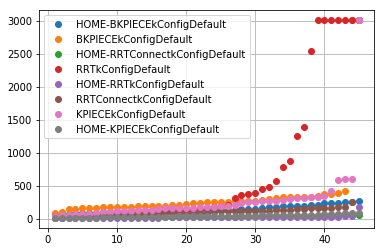

In [19]:
KEY_LIST = []
for k, v in gtimer.timelist_dict.items():
    v = sorted(v)[:int(len(v)*0.9)]
    plt.plot(np.arange(len(v))+1, sorted(v), 'o')
    KEY_LIST.append(k)
    print("{} - {} ms".format(k, np.mean(v)))
plt.legend(KEY_LIST)
plt.grid()

HOME-BKPIECEkConfigDefault - 346.106624603 ms
BKPIECEkConfigDefault - 3005.37004471 ms
HOME-RRTConnectkConfigDefault - 161.434555054 ms
RRTkConfigDefault - 3007.52835274 ms
HOME-RRTkConfigDefault - 421.1997509 ms
RRTConnectkConfigDefault - 3005.3565979 ms
KPIECEkConfigDefault - 3005.85722923 ms
HOME-KPIECEkConfigDefault - 161.339235306 ms


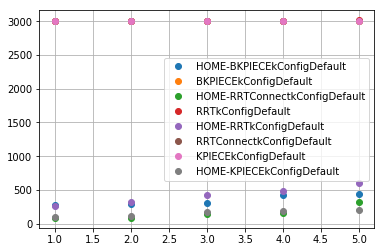

In [20]:
KEY_LIST = []
for k, v in gtimer.timelist_dict.items():
    v = sorted(v)[int(len(v)*0.9):]
    plt.plot(np.arange(len(v))+1, sorted(v), 'o')
    KEY_LIST.append(k)
    print("{} - {} ms".format(k, np.mean(v)))
plt.legend(KEY_LIST)
plt.grid()

#### grasp-reaching motion times
* without STOMP
```
BKPIECEkConfigDefault: 	17848.1 ms/50 = 357.0 ms (130.861/1005.99)
RRTkConfigDefault: 	33170.2 ms/50 = 663.4 ms (57.732/1007.893)
RRTConnectkConfigDefault: 	12987.8 ms/50 = 259.8 ms (54.521/1006.136)
```
* with STOMP
```
BKPIECEkConfigDefault: 	43703.2 ms/50 = 874.1 ms (294.829/6632.013)
RRTkConfigDefault: 	50027.4 ms/50 = 1000.5 ms (193.122/6222.588)
RRTConnectkConfigDefault: 	27541.5 ms/50 = 550.8 ms (205.684/3773.618)
```

### visualize trajectory

In [22]:
gtimer=GlobalTimer.instance()
gtimer.reset()
# grip 1 - reach the first waypoint
from_state = initial_state.copy(pscene)
from_state.Q = crob.home_pose
to_node = ("gripper", 0)
available_binding_dict = pscene.get_available_binding_dict(from_state, to_node)
available_binding_dict = {'box1': [('handle2', 'grip0', 'gripper')],
                          'sweep': [(None, None, None)]}
to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)
with gtimer.block("RRTConnectkConfigDefault"):
    Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=3, 
                                                                      plannerconfig=PlannerConfig.RRTConnectkConfigDefault)
gscene.clear_highlight()
gscene.show_motion(Traj, period=0.05)
sweep_face.draw_traj_coords(Traj, "traj_{}".format(sweep_face.name))

try transition motion
transition motion tried: True


[array([[ 1.00000000e+00,  7.79863949e-16, -9.97716006e-16,
          3.49999987e-01],
        [-7.79863925e-16,  1.00000000e+00, -1.12647015e-15,
         -1.86499992e-01],
        [ 9.97716006e-16,  1.12647018e-15,  1.00000000e+00,
          3.21499992e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([[ 0.99692951, -0.07758312, -0.01060357,  0.36594458],
        [ 0.07791202,  0.99633644,  0.03526223, -0.18694306],
        [ 0.00782897, -0.0359801 ,  0.99932187,  0.32443458],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.98761022, -0.15339672, -0.03309811,  0.38582331],
        [ 0.15587135,  0.98332165,  0.09371614, -0.19396302],
        [ 0.01817034, -0.09771407,  0.99504865,  0.33555112],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.97171928, -0.22584126, -0.06897311,  0.40987479],
        [ 0.23442506,  0.95772604,  0.16675065, -0.20386734],
        [ 0.02839816, -0.1

In [19]:
gscene.show_pose(Traj[-2])

In [21]:
gscene.show_pose((Traj[-1]+Traj[-2])/2)

In [20]:
gscene.show_pose(Traj[-1])

### check default

In [ ]:
gtimer=GlobalTimer.instance()
gtimer.reset()
from_state = sweep1_state.copy(pscene)
to_node = ("floor", 2)
available_binding_dict = pscene.get_available_binding_dict(from_state, to_node)
to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)
for _ in range(10):
    gtimer.tic("default")
    Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=10)
    gtimer.toc("default", stack=True)
print(gtimer)

# Compare post-processing

### prepare clearance checker

In [15]:
from pkg.utils.joint_utils import get_T_dict_foward
from pkg.utils.gjk import get_point_list, set_point_list, get_gjk_distance

def get_dists(gscene, geo_list_1, geo_list_2, Q_dict):
    T_dict = get_T_dict_foward("base_link", gscene.link_names, Q_dict, gscene.urdf_content)

    object_vertice_list = []
    for obj_geo in geo_list_1:
        T = np.matmul(T_dict[obj_geo.link_name], obj_geo.Toff)
        verts, radius = obj_geo.get_vertice_radius()
        verts = np.matmul(verts, T[:3 ,:3].transpose() ) +T[:3 ,3]
        vert_point_list = get_point_list(verts)
        object_vertice_list.append((vert_point_list, radius))

    clearance_vertice_list = []
    for gtem_clr in geo_list_2:
        T = np.matmul(T_dict[gtem_clr.link_name], gtem_clr.Toff)
        verts, radius = gtem_clr.get_vertice_radius()
        verts = np.matmul(verts, T[:3 ,:3].transpose() ) +T[:3 ,3]
        vert_point_list = get_point_list(verts)
        clearance_vertice_list.append((vert_point_list, radius))

    dist_list = []
    for clear_vertice, clear_radius in clearance_vertice_list:
        for object_vertice, object_radius in object_vertice_list:
            dist_list.append(get_gjk_distance(clear_vertice, object_vertice) - clear_radius - object_radius)
    return dist_list

get_dist_tmp = lambda Q: get_dists(gscene, 
                                                   [gtem for gtem in gscene if "indy" in gtem.link_name 
                                                                                           and "indy0_link0" not in gtem.link_name 
                                                                                           and "indy0_link1" not in gtem.link_name 
                                                                                           and gtem.collision], 
                                                   [gtem for gtem in gscene if "indy" not in gtem.link_name and gtem.collision], list2dict(Q, crob.joint_names))

## Prepare Postprocessing states

In [65]:
gtimer=GlobalTimer.instance()
gtimer.reset(scale=1.0, timeunit='s')
# grip 1 - reach the first waypoint
from_state = initial_state.copy(pscene)
from_state.Q = crob.home_pose
to_node = ("gripper", 0)
to_state_list = []
for _ in range(50):
    available_binding_dict = pscene.get_available_binding_dict(from_state, to_node)
    available_binding_dict = {'box1': [('handle2', 'grip0', 'gripper')],
                              'sweep': [(None, None, None)]}
    to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)
    for vv in redundancy_dict.values():
        for v in vv.values():
            v['w']=np.random.uniform(-np.pi/8, np.pi/8)
    for i in range(10):
        Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=3, 
                                                                          plannerconfig=PlannerConfig.RRTConnectkConfigDefault)
        if success:
            break
    to_state = from_state.copy(pscene)
    to_state.Q = LastQ
    to_state_list.append(to_state)

try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transition motion
transition motion tried: True
try transiti

In [66]:
results_dict = defaultdict(list)
traj_dict = defaultdict(list)
dist_dict = defaultdict(list)

# post-optimizing with CHOMP
***[IMPORTANT]*** Set last item of request_adapters in robots/planning_assets.yaml to chomp/OptimizerAdapter!!

In [81]:
mplan = MoveitPlanner(pscene)

In [83]:
to_state = np.random.choice(to_state_list)
Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=10, 
                                                                  plannerconfig=PlannerConfig.RRTConnectkConfigDefault, post_opt=True)
gscene.show_motion(Traj, period=0.01)

try joint motion
joint motion tried: True


In [80]:
gripper.draw_traj_coords(Traj[::5], "traj_{}".format(gripper.name))
print(len(Traj))

101


In [78]:
gscene.clear_highlight()

In [71]:
results_dict = defaultdict(list)
traj_dict = defaultdict(list)
dist_dict = defaultdict(list)

In [72]:
for to_state in to_state_list:
    with gtimer.block("RRTConnect", stack=True):
        Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=10, 
                                                                          plannerconfig=PlannerConfig.RRTConnectkConfigDefault)
    results_dict["RRTConnect"].append(success)
    if success:
        t_all, Traj = calc_safe_trajectory(2e-2, simplify_traj(Traj), vel_lims=0.5, acc_lims=0.5)
        traj_dict["RRTConnect"].append(sum(np.linalg.norm(Traj[1:]-Traj[:-1], axis=-1)))
        dist_dict["RRTConnect"].append(np.min([np.min(get_dist_tmp(Q)) for Q in Traj]))
    else:
        traj_dict["RRTConnect"].append(0)
        dist_dict["RRTConnect"].append(0)
        
    with gtimer.block("RRTConnect_CHOMP", stack=True):
        Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=10, 
                                                                          plannerconfig=PlannerConfig.RRTConnectkConfigDefault, 
                                                                          post_opt=True)
    results_dict["RRTConnect_CHOMP"].append(success)
    if success:
        t_all, Traj = calc_safe_trajectory(2e-2, simplify_traj(Traj), vel_lims=0.5, acc_lims=0.5)
        traj_dict["RRTConnect_CHOMP"].append(sum(np.linalg.norm(Traj[1:]-Traj[:-1], axis=-1)))
        dist_dict["RRTConnect_CHOMP"].append(np.min([np.min(get_dist_tmp(Q)) for Q in Traj]))
    else:
        traj_dict["RRTConnect_CHOMP"].append(0)
        dist_dict["RRTConnect_CHOMP"].append(0)
    print("-------------------------------")

try joint motion
joint motion tried: True
try joint motion
joint motion tried: False
-------------------------------
try joint motion
joint motion tried: True
try joint motion
joint motion tried: False
-------------------------------
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
-------------------------------
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
-------------------------------
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
-------------------------------
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
-------------------------------
try joint motion
joint motion tried: True
try joint motion
joint motion tried: False
-------------------------------
try joint motion
joint motion tried: True
try joint motion
joint motion tried: True
-------------------------------
try joint motion
joint motion tried: True
try joint motion
joint moti

In [73]:
print("=== [results] ===")
for k, v in results_dict.items():
    print("{}: {}".format(k, np.round(np.mean(v), 2)))
print("=== [Min/Median/Mean/Max time] ===")
for k, v in gtimer.timelist_dict.items():
    v= np.array(v)[np.where(results_dict[k])[0]]
    print("{}: {} / {} / {} / {}".format(k, 
                                         np.round(np.min(v), 2), np.round(np.median(v), 2), 
                                         np.round(np.mean(v), 2), np.round(np.max(v), 2)))
print("=== [Min/Median/Mean/Max path] ===")
for k, v in traj_dict.items():
    v= np.array(v)[np.where(results_dict[k])[0]]
    print("{}: {} / {} / {} / {}".format(k, 
                                         np.round(np.min(v), 2), np.round(np.median(v), 2), 
                                         np.round(np.mean(v), 2), np.round(np.max(v), 2)))
print("=== [Min/Median/Mean/Max dist] ===")
for k, v in dist_dict.items():
    v= np.array(v)[np.where(results_dict[k])[0]]*1000
    print("{}: {} / {} / {} / {}".format(k, 
                                         np.round(np.min(v), 2), np.round(np.median(v), 2), 
                                         np.round(np.mean(v), 2), np.round(np.max(v), 2)))

=== [results] ===
RRTConnect: 1.0
RRTConnect_CHOMP: 0.78
=== [Min/Median/Mean/Max time] ===
RRTConnect: 0.03 / 0.05 / 0.06 / 0.18
RRTConnect_CHOMP: 0.23 / 0.27 / 0.36 / 0.77
=== [Min/Median/Mean/Max path] ===
RRTConnect: 2.42 / 3.47 / 3.72 / 7.46
RRTConnect_CHOMP: 2.43 / 2.64 / 3.54 / 6.62
=== [Min/Median/Mean/Max dist] ===
RRTConnect: 0.0 / 1.74 / 2.94 / 11.12
RRTConnect_CHOMP: 0.0 / 5.44 / 4.57 / 9.86


In [47]:
Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=10, 
                                                                  plannerconfig=PlannerConfig.RRTConnectkConfigDefault)
t_all, Traj_safe = calc_safe_trajectory(2e-2, simplify_traj(Traj), vel_lims=0.5, acc_lims=0.5)
gscene.show_motion(Traj_safe, period=0.001)

try joint motion
joint motion tried: True


In [48]:
import matplotlib.pyplot as plt
dist_mm = np.multiply(1e3, [np.min(get_dist_tmp(Q)) for Q in Traj_safe])
plt.plot(dist_mm)
plt.grid()
print(np.min(dist_mm))

1.3918913847527696e-15


In [52]:
Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=10, 
                                                                  plannerconfig=PlannerConfig.RRTConnectkConfigDefault, post_opt=True)
t_all, Traj_safe_opt = calc_safe_trajectory(2e-2, simplify_traj(Traj), vel_lims=0.5, acc_lims=0.5)
gscene.show_motion(Traj_safe_opt, period=0.001)

try joint motion
joint motion tried: True


2.514808838617923


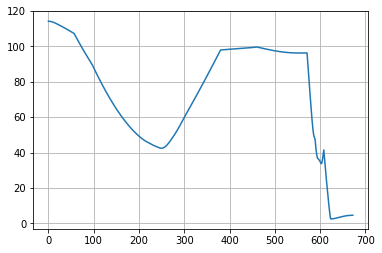

In [462]:
import matplotlib.pyplot as plt
dist_mm = np.multiply(1e3, [np.min(get_dist_tmp(Q)) for Q in Traj_safe_opt])
plt.plot(dist_mm)
plt.grid()
print(np.min(dist_mm))

In [258]:
# gscene.clear_highlight()
# gripper.draw_traj_coords(Traj, "traj_{}".format(gripper.name))
# print(len(Traj))

101


# post-optimizing with STOMP
***[IMPORTANT]*** Set last item of request_adapters in robots/planning_assets.yaml to stomp_moveit/StompSmoothingAdapter!!

In [20]:
mplan = MoveitPlanner(pscene)

In [21]:
for to_state in to_state_list:
    with gtimer.block("RRTConnect_STOMP", stack=True):
        Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=10, 
                                                                          plannerconfig=PlannerConfig.RRTConnectkConfigDefault, post_opt=True)
    results_dict["RRTConnect_STOMP"].append(success)
    if success:
        traj_dict["RRTConnect_STOMP"].append(sum(np.linalg.norm(Traj[1:]-Traj[:-1], axis=-1)))
        dist_dict["RRTConnect_STOMP"].append(np.min([np.min(get_dist_tmp(Q)) for Q in Traj]))
    else:
        traj_dict["RRTConnect_STOMP"].append(0)
        dist_dict["RRTConnect_STOMP"].append(0)
    print("-------------------------------")

try joint motion
joint motion tried: False
-------------------------------
try joint motion
joint motion tried: True
-------------------------------
try joint motion
joint motion tried: True
-------------------------------
try joint motion
joint motion tried: True
-------------------------------
try joint motion
joint motion tried: False
-------------------------------
try joint motion
joint motion tried: True
-------------------------------
try joint motion
joint motion tried: True
-------------------------------
try joint motion
joint motion tried: True
-------------------------------
try joint motion
joint motion tried: True
-------------------------------
try joint motion
joint motion tried: True
-------------------------------


In [ ]:
Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=10, 
                                                                  plannerconfig=PlannerConfig.RRTConnectkConfigDefault, post_opt=True)
gscene.show_motion(Traj, period=0.01)

# optimal path planning with RRT*

In [149]:
from_state = initial_state.copy(pscene)
from_state.Q = crob.home_pose
to_node = ("gripper", 0)
for to_state in to_state_list:
    with gtimer.block("RRTstar", stack=True):
        Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=30, 
                                                                          plannerconfig=PlannerConfig.RRTstarkConfigDefault)
    results_dict["RRTstar"].append(success)
    if success:
        traj_dict["RRTstar"].append(sum(np.linalg.norm(Traj[1:]-Traj[:-1], axis=-1)))
        dist_dict["RRTstar"].append(np.min([np.min(get_dist_tmp(Q)) for Q in Traj]))
    else:
        traj_dict["RRTstar"].append(0)
        dist_dict["RRTstar"].append(0)
    print("-------------------------------")

try joint motion


KeyboardInterrupt: 

In [ ]:
Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=10, 
                                                                  plannerconfig=PlannerConfig.RRTConnectkConfigDefault, post_opt=True)
gscene.show_motion(Traj, period=0.01)

In [34]:
print("=== [results] ===")
for k, v in results_dict.items():
    print("{}: {}".format(k, np.round(np.mean(v), 2)))
print("=== [Min/Median/Mean/Max time] ===")
for k, v in gtimer.timelist_dict.items():
    v= np.array(v)[np.where(results_dict[k])[0]]
    print("{}: {} / {} / {} / {}".format(k, 
                                         np.round(np.min(v), 2), np.round(np.median(v), 2), 
                                         np.round(np.mean(v), 2), np.round(np.max(v), 2)))
print("=== [Min/Median/Mean/Max path] ===")
for k, v in traj_dict.items():
    v= np.array(v)[np.where(results_dict[k])[0]]
    print("{}: {} / {} / {} / {}".format(k, 
                                         np.round(np.min(v), 2), np.round(np.median(v), 2), 
                                         np.round(np.mean(v), 2), np.round(np.max(v), 2)))
print("=== [Min/Median/Mean/Max dist] ===")
for k, v in dist_dict.items():
    v= np.array(v)[np.where(results_dict[k])[0]]*1000
    print("{}: {} / {} / {} / {}".format(k, 
                                         np.round(np.min(v), 2), np.round(np.median(v), 2), 
                                         np.round(np.mean(v), 2), np.round(np.max(v), 2)))

=== [results] ===
RRTConnect_CHOMP: 0.8
RRTConnect_STOMP: 0.8
RRTstar: 0.1
=== [Min/Max time] ===
=== [Mean time] ===
=== [Median time] ===
=== [Min/Max path] ===
RRTConnect_CHOMP: 2.51 / 3.9
RRTConnect_STOMP: 2.57 / 6.62
RRTstar: 2.56 / 2.56
=== [Mean path] ===
RRTConnect_CHOMP: 2.88
RRTConnect_STOMP: 3.82
RRTstar: 2.56
=== [Median path] ===
RRTConnect_CHOMP: 2.61
RRTConnect_STOMP: 3.01
RRTstar: 2.56
=== [Min/Max dist] ===
RRTConnect_CHOMP: 0.39 / 4.38
RRTConnect_STOMP: 3.2 / 4.69
RRTstar: 0.09 / 0.09
=== [Mean dist] ===
RRTConnect_CHOMP: 2.02
RRTConnect_STOMP: 4.22
RRTstar: 0.09
=== [Median dist] ===
RRTConnect_CHOMP: 1.51
RRTConnect_STOMP: 4.45
RRTstar: 0.09


### for record, time step comparison

In [17]:
print("TIMESTEP 100")
print("=== [Mean time] ===")
print(gtimer)
print("=== [Median time] ===")
for k, v in gtimer.timelist_dict.items():
    print("{}: {}".format(k, np.round(np.median(v), 2)))
print("=== [results] ===")
for k, v in results_dict.items():
    print("{}: {}".format(k, np.round(np.mean(v), 2)))

TIMESTEP 100
=== [Mean time] ===
RRTConnectkConfigDefault: 	108.5 s/5 = 21.7 s (0.397/37.634)
RRTstarkConfigDefault: 	129.9 s/5 = 26.0 s (8.964/30.385)

=== [Median time] ===
RRTstarkConfigDefault: 30.14
RRTConnectkConfigDefault: 33.77
=== [results] ===
RRTstarkConfigDefault: 0.2
RRTConnectkConfigDefault: 0.4


In [30]:
print("STOMP TIMESTEP 5")
print("=== [Mean time] ===")
print(gtimer)
print("=== [Median time] ===")
for k, v in gtimer.timelist_dict.items():
    print("{}: {}".format(k, np.round(np.median(v), 2)))
print("=== [results] ===")
for k, v in results_dict.items():
    print("{}: {}".format(k, np.round(np.mean(v), 2)))

TIMESTEP 5
=== [Mean time] ===
RRTConnectkConfigDefault: 	57.0 s/5 = 11.4 s (0.429/46.673)
RRTstarkConfigDefault: 	128.2 s/5 = 25.6 s (7.375/30.352)

=== [Median time] ===
RRTstarkConfigDefault: 30.25
RRTConnectkConfigDefault: 0.8
=== [results] ===
RRTstarkConfigDefault: 0.2
RRTConnectkConfigDefault: 0.8


# Test TrajOpt - Fail: bad_function_call

In [22]:
gtimer=GlobalTimer.instance()
gtimer.reset(scale=1.0, timeunit='s')
# grip 1 - reach the first waypoint
from_state = initial_state.copy(pscene)
from_state.Q = crob.home_pose
to_node = ("gripper", 0)
results_dict = defaultdict(list)
for _ in range(1):
    available_binding_dict = pscene.get_available_binding_dict(from_state, to_node)
    available_binding_dict = {'box1': [('handle2', 'grip0', 'gripper')],
                              'sweep': [(None, None, None)]}
    to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)
    for vv in redundancy_dict.values():
        for v in vv.values():
            v['w']=np.random.uniform(-np.pi/16, np.pi/16)
    for i in range(10):
        Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=3, 
                                                                          plannerconfig=PlannerConfig.RRTConnectkConfigDefault)
        if success:
            break
    with gtimer.block("TrajOptDefault"):
        Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=30, 
                                                                          plannerconfig=PlannerConfig.TrajOptDefault)
        results_dict["TrajOptDefault"].append(success)
    print("-------------------------------")
if success:
    pscene.set_object_state(from_state)
    gscene.show_motion(Traj, period=0.01)
    sweep1_state = pscene.rebind_all(binding_list, LastQ)
else:
    print("Solution not found. Please try again, try to find error if it keeps failing.")
#     raise(RuntimeError("Motion plan failure"))
print("")
print("============= [Timer] =============")
print(gtimer)
print("============= [Result] =============")
for k, v in results_dict.items():
    print("{}: {}".format(k, np.round(np.mean(v), 2)))

try transition motion
transition motion tried: True
try transition motion
transition motion tried: False
-------------------------------
Solution not found. Please try again, try to find error if it keeps failing.

============= [Timer] =============
TrajOptDefault: 	0.0 s/1 = 0.0 s (0.003/0.003)

============= [Result] =============
TrajOptDefault: 0.0


### test time

In [20]:
import random
from pkg.planning.motion.moveit.moveit_py import ConstrainedSpaceType
cs_types = [ConstrainedSpaceType.PROJECTED, ConstrainedSpaceType.ATLAS, ConstrainedSpaceType.TANGENTBUNDLE]

In [21]:
gtimer = GlobalTimer.instance()
gtimer.reset()
# sweep motion 2 - sweep "floor" to the second waypoint. Constrained motion planning takes longer time
suc_dict = defaultdict(list)
max_dict = defaultdict(list)
std_dict = defaultdict(list)
time_dict = defaultdict(list)
from_state = sweep1_state.copy(pscene)
to_node = ("floor", 2)
available_binding_dict = pscene.get_available_binding_dict(from_state, to_node)
to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)

In [22]:
for _ in range(10):    
    random.shuffle(cs_types)
    for cs_type in cs_types:
        gtimer.tic(cs_type.name)
        Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=10, cs_type=cs_type)
        elapsed = gtimer.toc(cs_type.name)
        suc_dict[cs_type.name].append(success)
        time_dict[cs_type.name].append(elapsed)
        if success:
            T_ref=floor.get_tf(crob.home_dict)
            Z_list = []
            for q in Traj:
                T_tool=sweep_face.get_tf(list2dict(q, crob.joint_names))
                Z_list.append(np.matmul(SE3_inv(T_ref), T_tool)[2,3])
            std_dict[cs_type.name].append(np.std(Z_list))
            max_dict[cs_type.name].append(np.max(Z_list)-np.min(Z_list))
    print(gtimer)

try constrained motion
constrained motion tried: True
try constrained motion
constrained motion tried: True
try constrained motion
constrained motion tried: True
PROJECTED: 	8351.0 ms/1 = 8351.42 ms (8351.42/8351.42)
TANGENTBUNDLE: 	100.0 ms/1 = 100.064 ms (100.064/100.064)
ATLAS: 	9418.0 ms/1 = 9418.117 ms (9418.117/9418.117)

try constrained motion
constrained motion tried: True
try constrained motion
constrained motion tried: True
try constrained motion
constrained motion tried: False
PROJECTED: 	8992.0 ms/2 = 4495.971 ms (640.522/8351.42)
TANGENTBUNDLE: 	612.0 ms/2 = 305.916 ms (100.064/511.767)
ATLAS: 	19422.0 ms/2 = 9711.086 ms (9418.117/10004.054)

try constrained motion
constrained motion tried: False
try constrained motion
constrained motion tried: False
try constrained motion
constrained motion tried: False
PROJECTED: 	19240.0 ms/3 = 6413.235 ms (640.522/10247.763)
TANGENTBUNDLE: 	10616.0 ms/3 = 3538.639 ms (100.064/10004.085)
ATLAS: 	29520.0 ms/3 = 9839.94 ms (9418.117/10097

In [23]:
import matplotlib.pyplot as plt
keys = ["PROJECTED", "ATLAS", "TANGENTBUNDLE"]

time_dict PROJECTED: 4172.3721981
time median PROJECTED: 2577.28695869
time_dict ATLAS: 8807.13708401
time median ATLAS: 10006.5795183
time_dict TANGENTBUNDLE: 1120.3234911
time median TANGENTBUNDLE: 51.3545274734


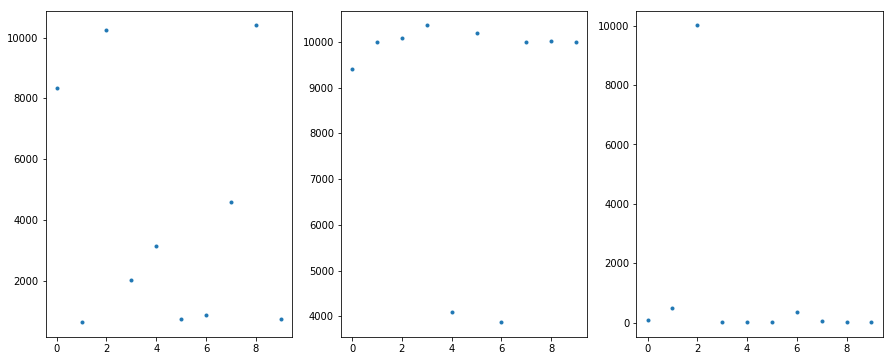

In [24]:
plt.figure(figsize=(15,6))
for i_k, k in enumerate(keys):
    v = time_dict[k]
    plt.subplot(1,3,i_k+1)
    plt.plot(v, '.')
    print("time_dict {}: {}".format(k, np.mean(v)))
    print("time median {}: {}".format(k, np.median(v)))

suc_dict PROJECTED: 0.8
suc_dict ATLAS: 0.3
suc_dict TANGENTBUNDLE: 0.9


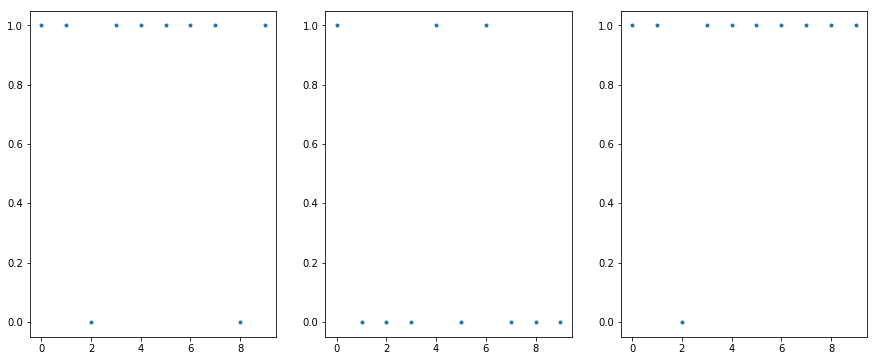

In [25]:
plt.figure(figsize=(15,6))
for i_k, k in enumerate(keys):
    v = suc_dict[k]
    plt.subplot(1,3,i_k+1)
    plt.plot(v, '.')
    print("suc_dict {}: {}".format(k, np.mean(v)))

std_dict PROJECTED: 9.4476031903e-05
std_dict ATLAS: 0.000139408717534
std_dict TANGENTBUNDLE: 0.000576285243079


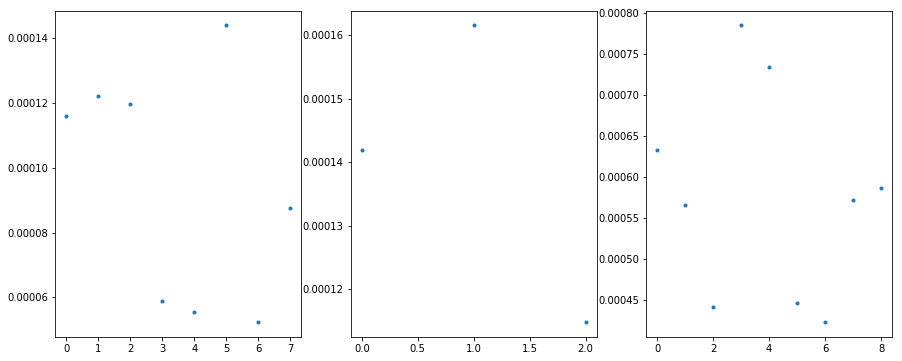

In [26]:
plt.figure(figsize=(15,6))
for i_k, k in enumerate(keys):
    v = std_dict[k]
    plt.subplot(1,3,i_k+1)
    plt.plot(v, '.')
    print("std_dict {}: {}".format(k, np.mean(v)))

max_dict PROJECTED: 0.000370803948808
max_dict ATLAS: 0.000621854875755
max_dict TANGENTBUNDLE: 0.00257926590836


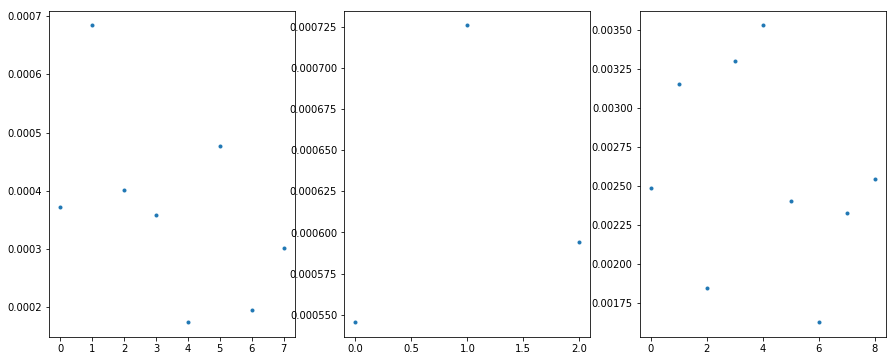

In [27]:
plt.figure(figsize=(15,6))
for i_k, k in enumerate(keys):
    v = max_dict[k]
    plt.subplot(1,3,i_k+1)
    plt.plot(v, '.')
    print("max_dict {}: {}".format(k, np.mean(v)))